<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/FrameStitcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Frame을 받아서 개별 프레임다위마다 스티칭을 하는 클래스 만들기


In [1]:
#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#드라이브안에서 프로젝트 드라이브로 이동
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [3]:
#from IPython.display import Image, display
import cv2, numpy as np

#Colab에서 imShow를 사용하기 위해 cv2_imshow를 사용한다.
from google.colab.patches import cv2_imshow

import math

#속도 관련 ORB 사용
#SIFT or SURF는 4.3이상의 버전에서만 사용가능하다. 
if cv2.__version__ != "4.4.0":
  print(cv2.__version__)
  #설치후에는 런타임을 재시작해줘야 한다.
  !pip install opencv-contrib-python==4.4.0.44

In [4]:
#먼저 업로드해둔 이미지 파일들
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])

In [5]:
#image의 외곽 좌표를 np.array로 리턴
def getImageCorner(img):
  h, w = img.shape[:2]
  return np.float32([ [0,0],[0,h],[w,h],[w,0]])

In [6]:
#입력 이미지의 그레이 이미지 복사본을 리턴
def getGrayImage(img):
  if len(img.shape) > 2:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else :
    return img.copy()

In [7]:
#dst의 roi 영역에 src 이미지를 설정
def copyImageROI(src, dst, x, y):
  h,w = src.shape[:2]
  #assert dst.shape[0] < y+h, "src size error"
  #assert dst.shape[1] < x+w, "src size error"

  dst[y:y+h, x: x+w] = src

In [49]:
def getTfCorner(c1, c2):
  corner = np.concatenate((c1, c2), axis=0)
  [xmin, ymin] = np.int32(corner.min(axis=0).ravel())
  [xmax, ymax] = np.int32(corner.max(axis=0).ravel())
  return xmax, xmin, ymax, ymin

In [60]:

class FrameStitcher:
  def __init__(self, w, h):
    #ORB Dector init   
    #self.detector= cv2.ORB_create()
    self.detector = cv2.SIFT_create()

    #FLANN Matcher init
    #ORB
    #FLANN_INDEX_LSH = 6
    #index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12,\
    #                    multi_probe_level=1)

    #SIFT
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

    #최종 ROI 좌표
    self.current_roi = []
    
    #최소 매칭 수
    self.MIN_MATCH_COUNT = 4

    #현재 프레임 카운트
    self.frame_count = 0

    #최종 결과 이미지의 크기 설정 및 초기화
    self.output_frame_w = w
    self.output_frame_h = h
    self.outputframe = np.zeros((h,w,3), np.uint8)
    
    kernel = np.ones((5,5),np.uint8)
    self.kernel = (kernel == 1).astype('uint8')

    #변환 변수들 0 초기화
    #입력 프레임 크기
    self.frame_w = 0
    self.frame_h = 0

    #입력 프레임 코너 좌표
    self.frame_corner = []
    
    #마지막 변환 매트릭스
    self.M = np.array([[1,0,0], [0,1,0], [0,0,1]],np.float32)

    #마지막 프레임 keypoint, descriptor
    self.kp = None
    self.desc = None

  def initFirstFrame(self, frame):
    #카메라 프레임은 항상 동일한 크기로 가정
    self.frame_h, self.frame_w = frame.shape[:2]
    #동일한 영상이면 매 프레임마다 최외곽 좌표도 동일함
    self.frame_corner = getImageCorner(frame).reshape(-1,1,2)
    
    #화면 중앙으로 보내기 위한 변환 매트릭스 생성
    tx = math.floor(self.output_frame_w /2 - self.frame_w /2)
    ty = math.floor(self.output_frame_h/2 - self.frame_h /2)
    self.M = np.array([[1,0,tx],[0,1,ty],[0,0,1]],np.float32)
    
    kp, desc = self.findFeature(frame)
    self.kp = kp
    self.desc = desc

    #평행이동이라 계산 불필요
    #img1_tf_corner = cv2.perspectiveTransform(self.frame_corner, self.M)
    #초기 변환으로 첫 프레임을 결과 영상 센터로 이동 
    #tmp_frame = cv2.warpPerspective(frame,self.M,(self.frame_w, self.frame_h))

    #출력 프레임 roi에 이미지 설정
    copyImageROI(frame, self.outputframe, tx,ty)
    #초기 출력 영역 마스크 생성
    _, self.outputmask = cv2.threshold(self.outputframe, 0, 255, \
                                       cv2.THRESH_BINARY)
    
    #outputframe에서 마지막 추가된 프레임만의 영역
    self.current_roi = [tx, ty, self.frame_w, self.frame_h]
    self.frame_count += 1

    #cv2_imshow(self.outputframe)
    
  def setFrame(self, frame):
    #한번 실행되고 매번 검사하는 것은 고민해볼 문제
    if self.frame_count == 0:
      self.initFirstFrame(frame)

    kp1, desc1 = self.findFeature(frame)

    #print(desc1)
    #print(self.desc)
    good = self.findGoodMatch(desc1, self.desc)

    if len(good) < self.MIN_MATCH_COUNT:
      return self.outputframe

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])\
    .reshape(-1,1,2)
    dst_pts = np.float32([ self.kp[m.trainIdx].pt for m in good ])\
    .reshape(-1,1,2)

    #frame을 outputframe으로 변환 할 것이기 때문에
    tM, RANSAC_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    #외곽 좌표 변환
    corner = getImageCorner(frame).reshape(-1,1,2)  
    frame_tf_corner = cv2.perspectiveTransform(corner,tM)
    xmax, xmin, ymax, ymin = getTfCorner(self.frame_corner,frame_tf_corner)

    #새로운 ROI 설정
    roix = self.current_roi[0] + xmin
    roiy = self.current_roi[1] + ymin
    roiw = xmax - xmin
    roih = ymax - ymin

    #새로운 프레임의 시작 지점으로 ROI 시작 이동
    self.current_roi[0] += math.floor(frame_tf_corner[0][0][0])
    self.current_roi[1] += math.floor(frame_tf_corner[0][0][1])

    source_roi = self.outputframe[roiy:roiy+roih, roix:roix+roiw]
    #cv2_imshow(source_roi)

    #영상 변환 & 마스크 생성
    warp_img = cv2.warpPerspective(frame,tM,(roiw, roih))
    wg = getGrayImage(warp_img)
    _, warp_mask = cv2.threshold(wg, 1, 255, cv2.THRESH_BINARY)

    #Result Mask 기반 합성으로 변경 필요 - 겹치지 않는 영역이 생기지 않게
    warp_mask = cv2.erode(warp_mask, self.kernel, borderType=cv2.BORDER_CONSTANT)
    ### 새로운 이미지 전체가 반영되도록 병합
    warp_mask_inv = cv2.bitwise_not(warp_mask)

    masked_fg = cv2.bitwise_and(warp_img, warp_img, mask=warp_mask)
    masked_bg = cv2.bitwise_and(source_roi, source_roi, mask=warp_mask_inv)
    added = masked_fg + masked_bg

    #cv2_imshow(added)
    self.outputframe[roiy:roiy+roih, roix:roix+roiw] = added

    #마지막 프레임 keypoint & descriptor update
    self.last_frame = frame
    self.kp = kp1
    self.desc = desc1
    self.frame_count += 1

  #2장의 이미지를 입력 받아서 keypoint와 변환 매트릭스를 리턴
  def findFeature(self, img,detector_type = 'SIFT', mask_enable=False,\
                min_match_count = 10):
    #흑백 이미지 생성
    img_gray = getGrayImage(img)

    #이미지에서 0인 영역으로 마스크를 생성시켜 계산의 속도 향상, 
    #검은 영역이 없다면 무쓸모
    mask = None
    if(mask_enable):
      _, mask = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    
    #keypoint와 Descriptor 찾기
    kp, desc = self.detector.detectAndCompute(img, mask)

    return kp, desc

  #Descriptor를 비교하여 매치 상태가 좋은 점들만 리턴
  def findGoodMatch(self, desc1, desc2, \
                     matcher_type = 'FLANN', \
                     best_match_count = 2, \
                     match_dist = 0.7): 
    matches = self.matcher.knnMatch(desc1,desc2,k=best_match_count)

    good = []
    for m_n in matches:
      if len(m_n) != 2:
        continue
      (m,n) = m_n
      if m.distance < match_dist *n.distance:
          good.append(m)
    return good


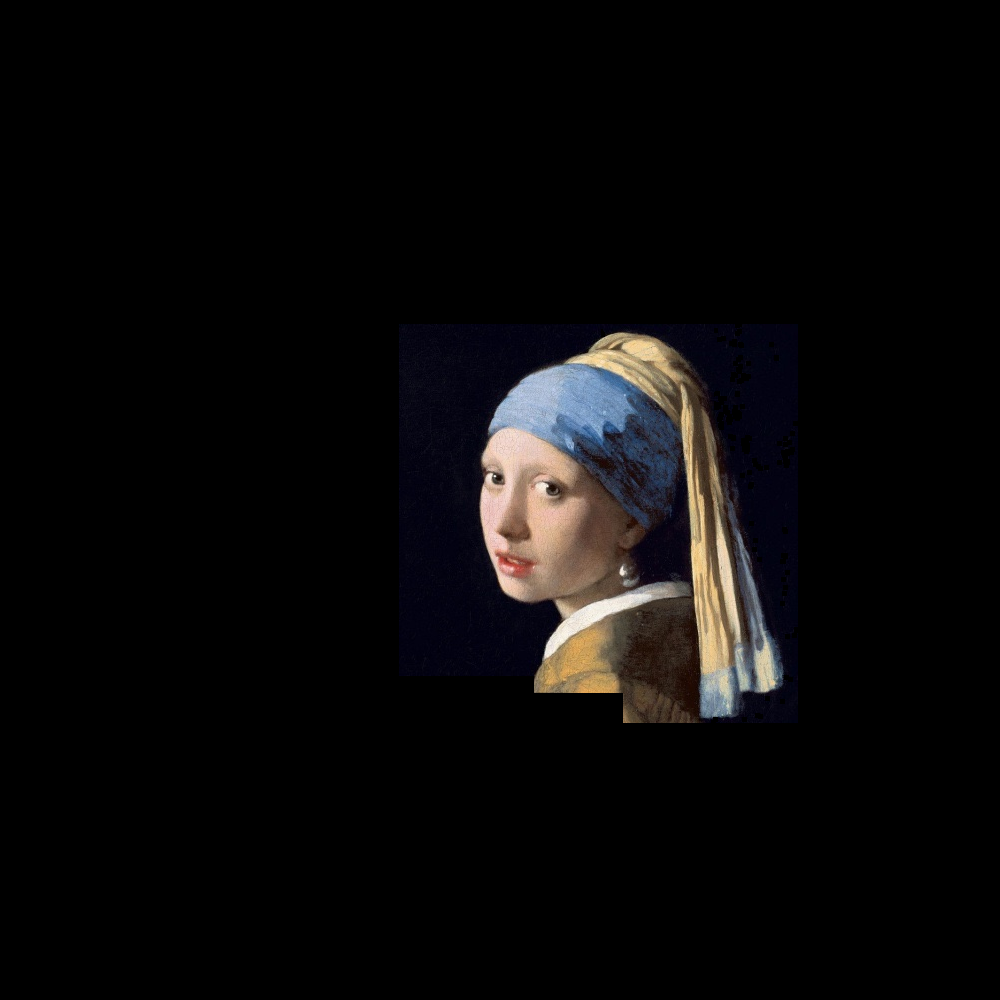

In [61]:
fs = FrameStitcher(1000,1000)
fs.initFirstFrame(img1)
fs.setFrame(img2)
fs.setFrame(img3)

cv2_imshow(fs.outputframe)
